<a href="https://colab.research.google.com/github/maryapolyakova10112016/HW2/blob/main/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
%%writefile ml_module.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix
from typing import Optional, List

class MLModule:
    def __init__(self, file_path: str):
        self.file_path = file_path
        self.df = None
        self.model = None
        self.model_type = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None

    # -----------------------------
    # 1. Загрузка данных
    # -----------------------------
    def load_data(self, encoding='utf-8'):
        try:
            self.df = pd.read_csv(self.file_path, encoding=encoding)
            print("Data loaded successfully.")
            return self.df
        except Exception as e:
            print("Error loading data:", e)
            return None

    # -----------------------------
    # 2. Предобработка данных
    # -----------------------------
    def preprocess_data(self):
        if self.df is None:
            print("Data not loaded yet!")
            return None
        self.df.drop_duplicates(inplace=True)
        self.df.reset_index(drop=True, inplace=True)
        print("Preprocessing completed.")
        return self.df

    # -----------------------------
    # 3. Пропущенные значения
    # -----------------------------
    def missing_values_count(self):
        if self.df is None:
            print("Data not loaded yet!")
            return None
        return self.df.isna().sum()

    def missing_values_report(self):
        if self.df is None:
            print("Data not loaded yet!")
            return
        report = self.df.isna().sum().reset_index()
        report.columns = ['Column', 'MissingValues']
        print(report)

    def fill_missing_values(self, strategy: str = 'mean', columns: Optional[List[str]] = None):
        if self.df is None:
            print("Data not loaded yet!")
            return
        cols = columns if columns else self.df.columns
        for col in cols:
            if pd.api.types.is_numeric_dtype(self.df[col]):
                if strategy == 'mean':
                    self.df[col] = pd.to_numeric(self.df[col], errors='coerce').fillna(self.df[col].mean())
                elif strategy == 'median':
                    self.df[col] = pd.to_numeric(self.df[col], errors='coerce').fillna(self.df[col].median())
                elif strategy == 'mode':
                    self.df[col] = pd.to_numeric(self.df[col], errors='coerce').fillna(self.df[col].mode()[0])
            else:
                self.df[col] = self.df[col].fillna(self.df[col].mode()[0])
        print(f"Missing values filled using {strategy} strategy.")

    # -----------------------------
    # 4. Визуализации
    # -----------------------------
    def plot_histogram(self, column):
        plt.figure(figsize=(10,5))
        sns.histplot(self.df[column], kde=True, bins=30)
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()

    def plot_boxplot(self, x_col, y_col):
        plt.figure(figsize=(12,6))
        sns.boxplot(data=self.df, x=x_col, y=y_col)
        plt.title(f'{y_col} across {x_col}')
        plt.xlabel(x_col)
        plt.ylabel(y_col)
        plt.xticks(rotation=45)
        plt.show()

    def plot_countplot(self, column):
        plt.figure(figsize=(10,5))
        sns.countplot(data=self.df, x=column, order=self.df[column].value_counts().index)
        plt.title(f'Count of each {column}')
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()

    def plot_corr_heatmap(self):
        numeric_df = self.df.select_dtypes(include=[np.number])
        if numeric_df.shape[1] >= 2:
            plt.figure(figsize=(10,8))
            sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
            plt.title('Correlation Heatmap')
            plt.show()
        else:
            print("Not enough numeric columns for heatmap.")

    def plot_pairplot(self):
        numeric_df = self.df.select_dtypes(include=[np.number])
        if numeric_df.shape[1] >= 2:
            sns.pairplot(numeric_df)
            plt.show()
        else:
            print("Not enough numeric data for pairplot.")

    def plot_top_n(self, column, n=10):
        plt.figure(figsize=(12,6))
        top_counts = self.df[column].value_counts().head(n)
        sns.barplot(x=top_counts.values, y=top_counts.index, palette='Greens_r')
        plt.title(f'Top {n} {column} counts')
        plt.xlabel('Count')
        plt.ylabel(column)
        plt.tight_layout()
        plt.show()

    # -----------------------------
    # 5. Статистика
    # -----------------------------
    def describe_data(self):
        if self.df is None:
            print("Data not loaded yet!")
            return None
        return self.df.describe()

    # -----------------------------
    # 6. Predictive Modeling
    # -----------------------------
    def train_model(self, target: str, features: Optional[List[str]] = None, model_type: Optional[str] = None):
        if self.df is None:
            print("Data not loaded yet!")
            return
        X = self.df[features] if features else self.df.drop(columns=[target])
        y = self.df[target]

        # Определяем тип модели автоматически
        if model_type is None:
            if y.dtype in ['int64', 'float64'] and len(y.unique()) > 10:
                model_type = 'regression'
            else:
                model_type = 'classification'

        # One-hot encode категориальные признаки
        categorical = X.select_dtypes(include=['object', 'category']).columns.tolist()
        if categorical:
            X = pd.get_dummies(X, columns=categorical, drop_first=True)
        X = X.fillna(X.mean())

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        if model_type == 'regression':
            self.model = LinearRegression()
        elif model_type == 'classification':
            self.model = LogisticRegression(max_iter=1000)
        else:
            raise ValueError("model_type must be 'regression' or 'classification'")

        self.model_type = model_type
        self.model.fit(self.X_train, self.y_train)
        print(f"{model_type.capitalize()} model trained successfully.")

    def predict(self, X_new: pd.DataFrame):
        if self.model is None:
            print("Model not trained yet!")
            return
        X_new = pd.get_dummies(X_new)
        X_new = X_new.reindex(columns=self.X_train.columns, fill_value=0)
        return self.model.predict(X_new)

    def evaluate_model(self):
        if self.model is None:
            print("Model not trained yet!")
            return

        y_pred = self.model.predict(self.X_test)

        if self.model_type == 'regression':
            mse = mean_squared_error(self.y_test, y_pred)
            r2 = r2_score(self.y_test, y_pred)
            print(f"Regression Evaluation:\nMSE: {mse:.2f}\nR2: {r2:.2f}")
            return {'MSE': mse, 'R2': r2}
        else:  # classification
            acc = accuracy_score(self.y_test, y_pred)
            cm = confusion_matrix(self.y_test, y_pred)
            print(f"Classification Accuracy: {acc:.2f}")
            plt.figure(figsize=(10,8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title('Confusion Matrix')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.show()
            return {'Accuracy': acc, 'ConfusionMatrix': cm}


Overwriting ml_module.py


# Новый раздел

In [53]:
importlib.reload(ml_module)

<module 'ml_module' from '/content/ml_module.py'>

КЛАССИФИКАЦИЯ ВОЗРАСТНЫХ ГРУПП ЖЕРТВ
Data loaded successfully.
Preprocessing completed.
Missing values filled using mean strategy.

=== Оценка модели LogisticRegression ===
Accuracy: 0.36
Confusion Matrix:
[[ 0  1  2 12]
 [ 0  2 12 42]
 [ 0  1 14 44]
 [ 0  1 13 56]]


/tmp/ipython-input-3080421985.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ml.df['hour'] = pd.to_datetime(ml.df['time'], errors='coerce').dt.hour
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


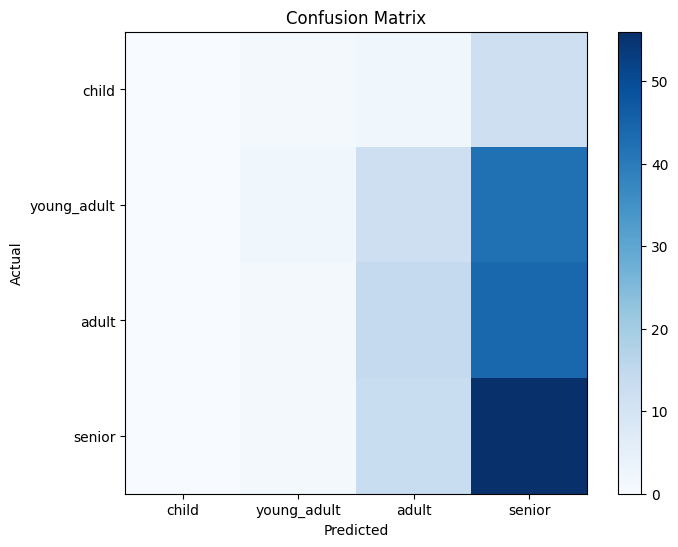

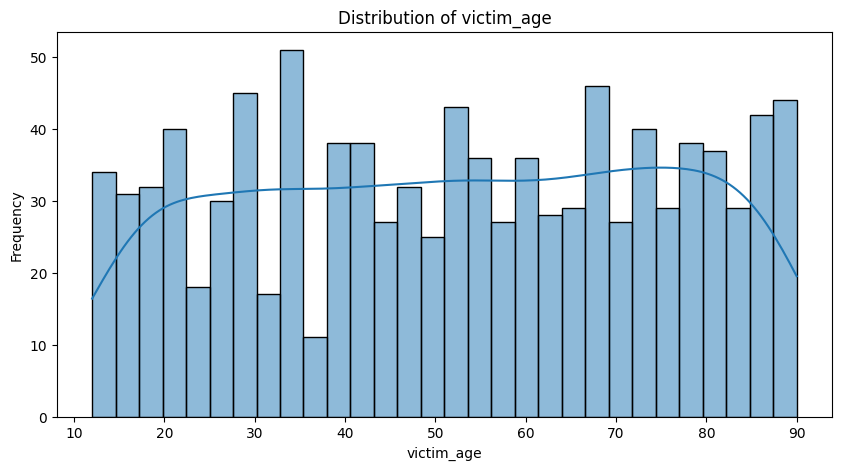

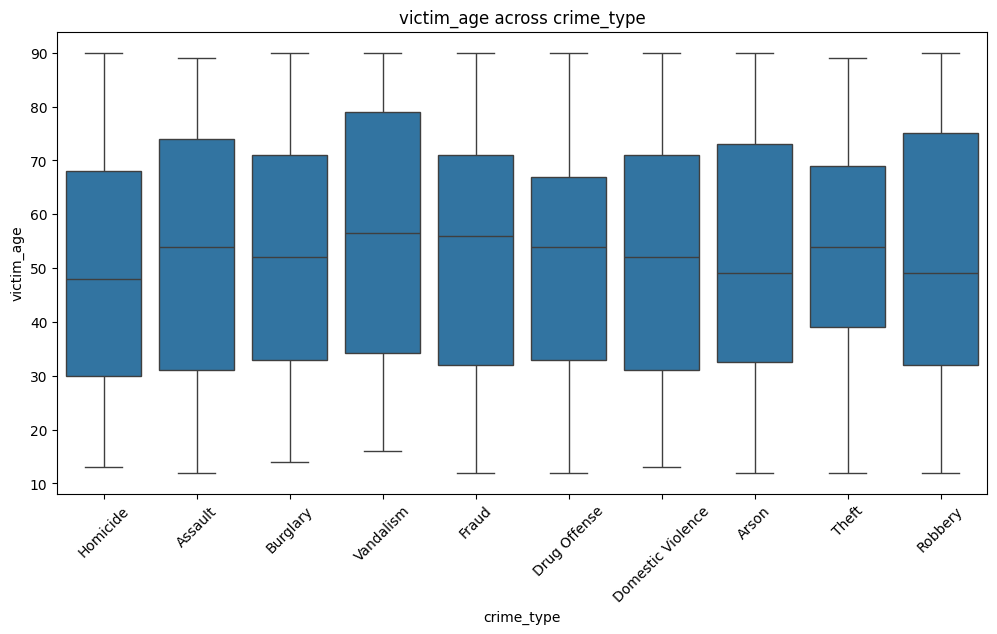

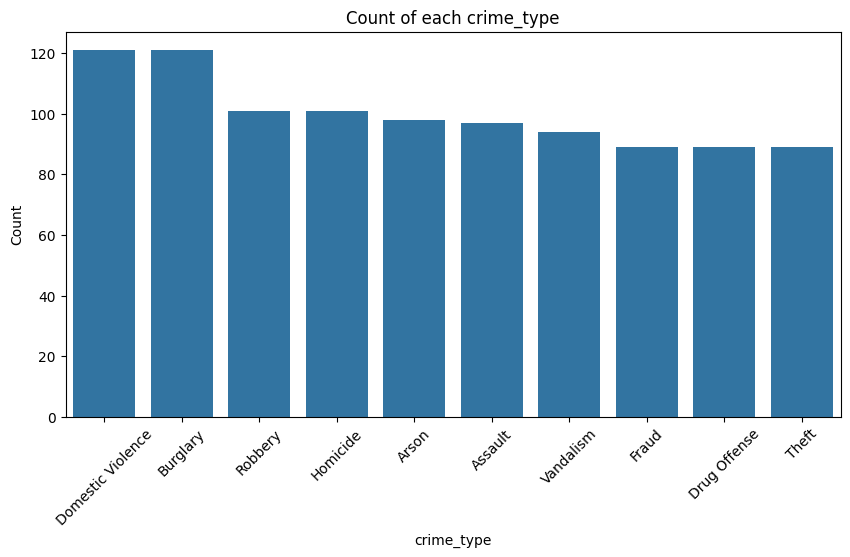

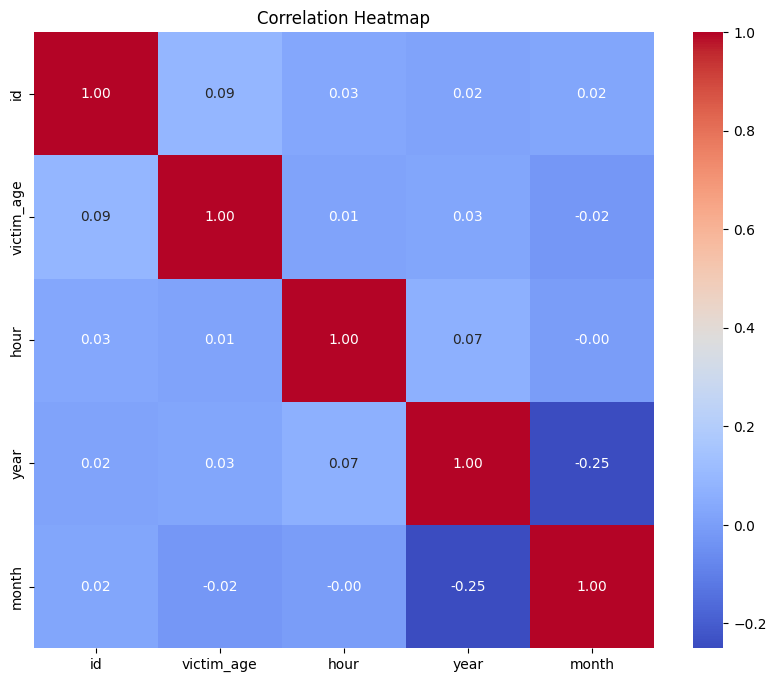

/content/ml_module.py:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='Greens_r')


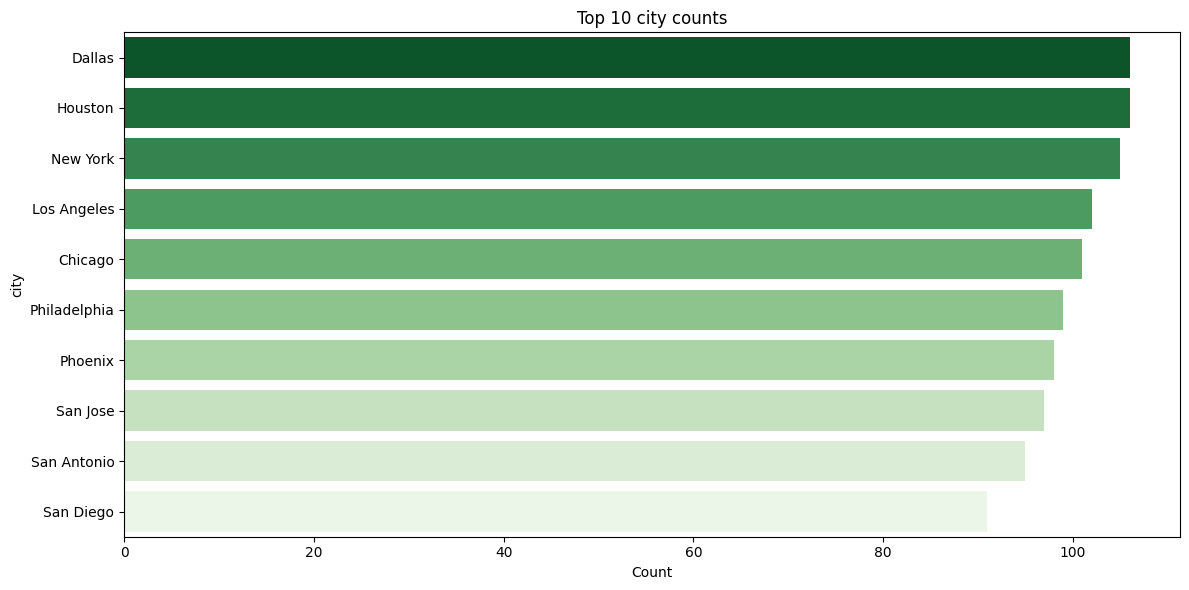


Анализ завершен!


In [73]:
import pandas as pd
from ml_module import MLModule
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

def main():
    print("КЛАССИФИКАЦИЯ ВОЗРАСТНЫХ ГРУПП ЖЕРТВ")
    print("=" * 80)

    # ----------------------
    # 1. Загрузка данных
    # ----------------------
    file_path = '/kaggle/input/crime-and-safety-dataset/crime_safety_dataset.csv'
    ml = MLModule(file_path)
    ml.load_data()
    ml.preprocess_data()

    # Извлекаем числовые признаки времени
    ml.df['hour'] = pd.to_datetime(ml.df['time'], errors='coerce').dt.hour
    ml.df['year'] = pd.to_datetime(ml.df['date'], errors='coerce').dt.year
    ml.df['month'] = pd.to_datetime(ml.df['date'], errors='coerce').dt.month

    # Ограничение категорий: топ-10 городов, остальные "Other"
    top_cities = ml.df['city'].value_counts().nlargest(10).index
    ml.df['city'] = ml.df['city'].apply(lambda x: x if x in top_cities else 'Other')

    # ----------------------
    # 2. Создаем возрастные группы
    # ----------------------
    def age_group(age):
        if age < 18:
            return 'child'
        elif age < 35:
            return 'young_adult'
        elif age < 60:
            return 'adult'
        else:
            return 'senior'

    ml.df['victim_age_group'] = ml.df['victim_age'].apply(age_group)

    # ----------------------
    # 3. Пропущенные значения
    # ----------------------
    ml.fill_missing_values(strategy='mean')

    # ----------------------
    # 4. Выбор признаков
    # ----------------------
    numeric_cols = ['hour', 'year', 'month']
    cat_cols = ['victim_gender', 'victim_race', 'city', 'state', 'crime_type']

    X_num = ml.df[numeric_cols]
    X_cat = pd.get_dummies(ml.df[cat_cols], drop_first=True)

    X_final = pd.concat([X_num.reset_index(drop=True), X_cat.reset_index(drop=True)], axis=1)
    y = ml.df['victim_age_group']

    # Масштабирование
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_final)

    # ----------------------
    # 5. Разделение данных
    # ----------------------
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # ----------------------
    # 6. Обучение модели
    # ----------------------
    model = LogisticRegression(multi_class='multinomial', max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # ----------------------
    # 7. Оценка модели
    # ----------------------
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred, labels=['child', 'young_adult', 'adult', 'senior'])

    print("\n=== Оценка модели LogisticRegression ===")
    print(f"Accuracy: {acc:.2f}")
    print("Confusion Matrix:")
    print(cm)

    # ----------------------
    # 8. Визуализация предсказаний
    # ----------------------
    plt.figure(figsize=(8,6))
    plt.imshow(cm, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xticks(ticks=range(4), labels=['child','young_adult','adult','senior'])
    plt.yticks(ticks=range(4), labels=['child','young_adult','adult','senior'])
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ----------------------
    # 9. Дополнительные графики
    # ----------------------
    ml.plot_histogram('victim_age')
    ml.plot_boxplot('crime_type', 'victim_age')
    ml.plot_countplot('crime_type')
    ml.plot_corr_heatmap()
    ml.plot_top_n('city', n=10)

    print("\nАнализ завершен!")

if __name__ == "__main__":
    main()
